In [ ]:
import pandas as pd
import numpy as np
import random
import datetime
import time
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import re
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Data')

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Data/facebook_combined.csv')
data.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [ ]:
data.columns = ['source_node', 'destination_node']

# Extract 1 lakh distinct nodes using .loc to avoid SettingWithCopyWarning
distinct_nodes = pd.concat([data['source_node'], data['destination_node']]).unique()[:100000]

filtered_data = data[
    (data['source_node'].isin(distinct_nodes) & (data['source_node'] <= 100000)) &
    (data['destination_node'].isin(distinct_nodes) & (data['destination_node'] <= 100000))
]

# Map nodes to new ranks starting from 1
node_mapping = {node: idx + 1 for idx, node in enumerate(distinct_nodes)}

# Use .loc to avoid SettingWithCopyWarning
filtered_data.loc[:, 'source_node'] = filtered_data['source_node'].map(node_mapping)
filtered_data.loc[:, 'destination_node'] = filtered_data['destination_node'].map(node_mapping)


# Save the filtered data to a file named "facebook_combined1.csv"
filtered_data.to_csv('facebook_combined1.csv', index=False)

data_wo = filtered_data.to_csv('/content/drive/My Drive/Data/fb_woheader.csv', header=False, index=False)

<ipython-input-6-dc7a712b4af7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'source_node'] = filtered_data['source_node'].map(node_mapping)
<ipython-input-6-dc7a712b4af7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'destination_node'] = filtered_data['destination_node'].map(node_mapping)


In [ ]:

print("Shape of the filtered dataset:", filtered_data.shape)
filtered_data.head()

Shape of the filtered dataset: (25812, 2)


,source_node,destination_node
15,4,5363
21,7,68674
26,10,26682
33,13,24487
42,13,31940


In [ ]:
Graphtype = nx.DiGraph()

In [ ]:
g = nx.read_edgelist('/content/drive/My Drive/Data/fb_woheader.csv', delimiter=',', create_using=Graphtype, nodetype=int)
print(g)

DiGraph with 21181 nodes and 25812 edges


# **Exploratory Data Analysis (EDA)**

In [ ]:
data = filtered_data
data.groupby('source_node')['source_node'].value_counts().sort_values()

source_node  source_node
4            4               1
52848        52848           1
52857        52857           1
52861        52861           1
52864        52864           1
                            ..
76194        76194          16
31662        31662          16
4021         4021           17
84849        84849          18
4138         4138           47
Name: source_node, Length: 18079, dtype: int64

In [ ]:
data.isna().any().sum()

0

#### **Description of Graph**

**Number of Nodes & Edges**

In [ ]:
# Graph statistics
G = nx.from_pandas_edgelist(data, source = 'source_node', target = 'destination_node', create_using=Graphtype)
print("Graph Information:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())
print("Graph Density:", nx.density(G))

# Print information about strongly connected components
strongly_connected_components = list(nx.strongly_connected_components(G))
print("Number of strongly connected components:", len(strongly_connected_components))
print("Sizes of the strongly connected components:", [len(comp) for comp in strongly_connected_components])

Graph Information:
Number of nodes: 21181
Number of edges: 25812
Average degree: 2.437278693168406
Graph Density: 5.753726848839485e-05
Number of strongly connected components: 11976
Sizes of the strongly connected components: [2, 2, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 7, 71, 11, 1, 1, 2, 2, 3, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 8, 3, 2, 2, 1, 3, 3, 3, 1, 6, 2, 2, 4, 2, 12, 6, 1, 1, 2, 1, 5, 1, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 5, 2, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 5, 6, 1, 1, 15, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 8, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 29, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 4, 8, 1, 1, 1, 2, 4, 1, 1, 1, 2, 2, 1, 4, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 4, 1, 1, 12, 1, 1, 4, 1, 4, 323, 3, 3, 2, 1, 1, 2, 2, 3, 6, 6, 1, 14, 1, 1, 3, 1, 1, 3, 2, 4, 4, 2, 3, 2, 9, 2, 9, 4, 1, 1, 2, 2, 2, 3, 1, 1, 2, 2, 3, 3, 1, 6, 4, 2, 1, 4, 2, 1, 1, 7, 1, 5, 2, 1, 14, 4, 3, 3, 2, 2, 1, 17, 2, 2, 1, 1, 1, 1, 4, 2, 1,

In [ ]:
data['source_node'].nunique()

18079

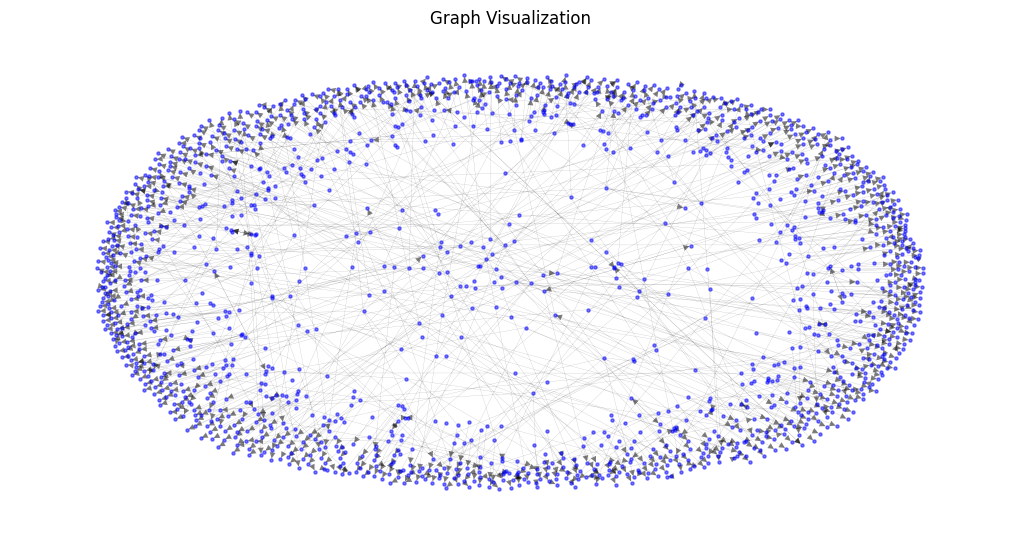

In [ ]:
G = nx.from_pandas_edgelist(data.head(1000), source = 'source_node', target = 'destination_node', create_using=Graphtype)
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 5))
nx.draw(
    G,
    pos,
    node_size = 5,
    node_color='b',
    width=0.1,
    alpha=0.5
)
plt.title("Graph Visualization")
plt.show()

In [ ]:
G = nx.from_pandas_edgelist(data, source = 'source_node', target = 'destination_node', create_using=Graphtype)

Number of isolated nodes: 0


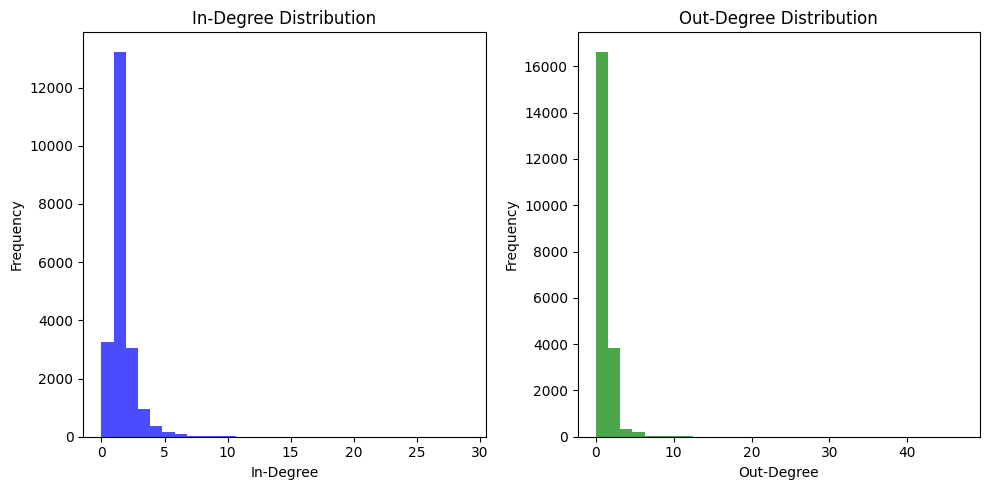

In [ ]:
isolated_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
print("Number of isolated nodes:", len(isolated_nodes))

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(list(in_degrees.values()), bins=30, color='blue', alpha=0.7)
plt.title('In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

plt.subplot(122)
plt.hist(list(out_degrees.values()), bins=30, color='green', alpha=0.7)
plt.title('Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

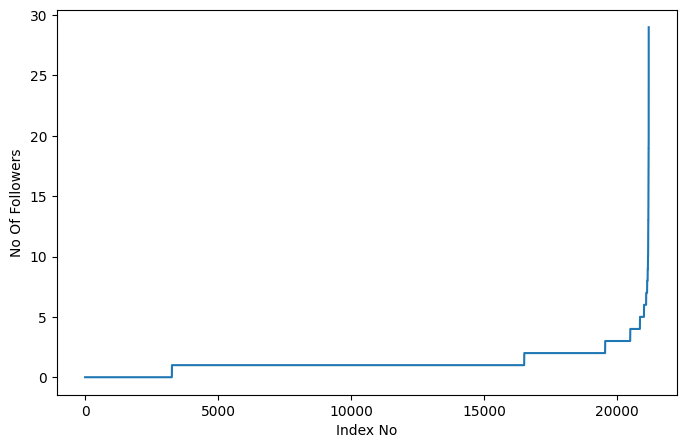

In [ ]:
indegree_dist = list(dict(G.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(8,5))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

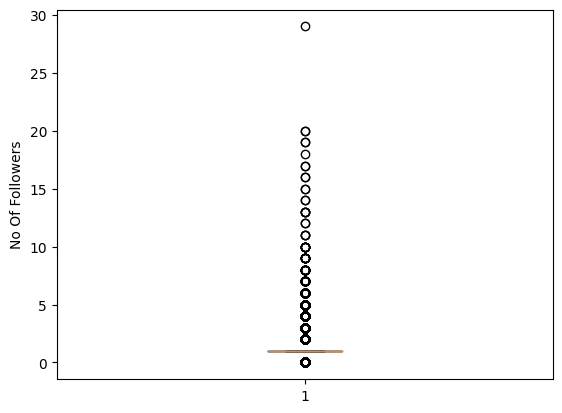

In [ ]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [ ]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 2.0
91 percentile value is 2.0
92 percentile value is 2.0
93 percentile value is 3.0
94 percentile value is 3.0
95 percentile value is 3.0
96 percentile value is 3.0
97 percentile value is 4.0
98 percentile value is 4.0
99 percentile value is 5.0
100 percentile value is 29.0


<ipython-input-20-d745a1f0e267>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(indegree_dist, color='#16A085')


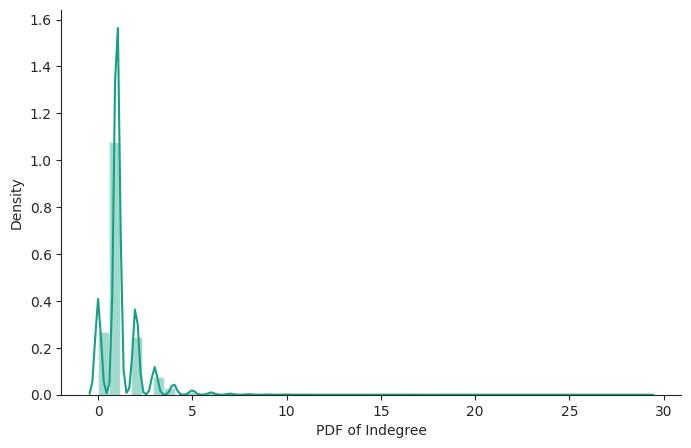

In [ ]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

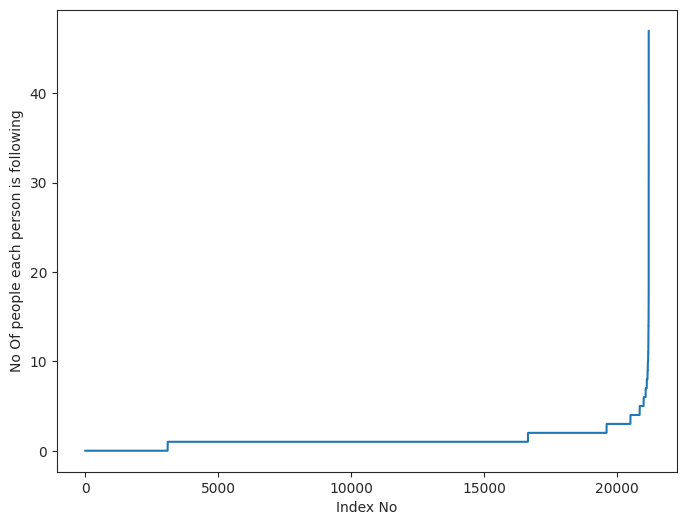

In [ ]:
outdegree_dist = list(dict(G.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(8,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [ ]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 3102 and % is 14.645200887587933


In [ ]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 3261 and % is 15.39587366035598


In [ ]:
from collections import Counter
dict_in = dict(G.in_degree())
dict_out = dict(G.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

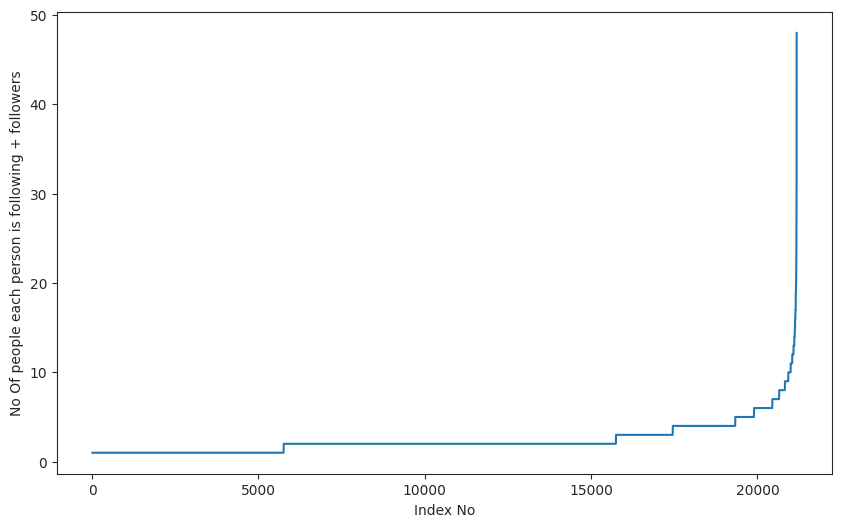

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 4.0
91 percentile value is 4.0
92 percentile value is 5.0
93 percentile value is 5.0
94 percentile value is 6.0
95 percentile value is 6.0
96 percentile value is 6.0
97 percentile value is 7.0
98 percentile value is 8.0
99 percentile value is 10.0
100 percentile value is 48.0


In [ ]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
5756  persons having minimum no of followers + following


In [ ]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 48
1  persons having maximum no of followers + following


In [ ]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 20927


In [ ]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(G))))
count=0
for i in list(nx.weakly_connected_components(G)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 6690
weakly connected components wit 2 nodes 4545


In [ ]:
# Calculate reciprocity (percentage of edges that are part of a directed cycle)
reciprocity = nx.reciprocity(G)
print(f"Reciprocity: {reciprocity:.4f}")

Reciprocity: 0.7438


 **Degree Distribution**

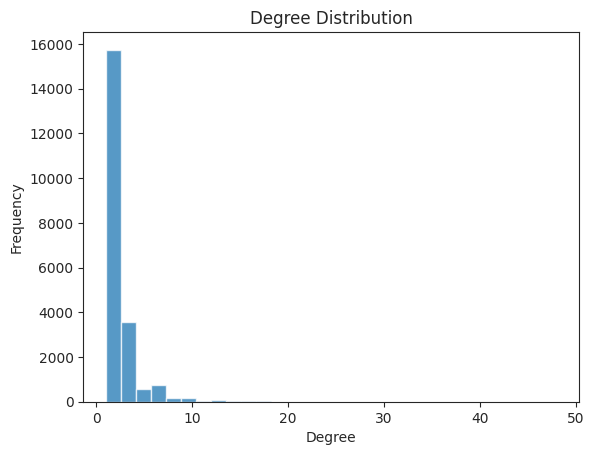

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.hist(degree_sequence, bins=30, alpha=0.75)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# in_degree_clustering = nx.average_clustering(G.to_undirected(), weight=None)
# print("In-degree clustering coefficient:", in_degree_clustering)

# out_degree_clustering = nx.average_clustering(G.reverse().to_undirected(), weight=None)
# print("Out-degree clustering coefficient:", out_degree_clustering)

# Generate Missing Edges

In [ ]:
r = csv.reader(open('fb_woheader.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

In [ ]:
import random
missing_edges = set([])
while (len(missing_edges)<10000):
    a=random.randint(1, 1862220)
    b=random.randint(1, 1862220)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a!=b:
        try:
            if nx.shortest_path_length(g,source=a,target=b) > 2:

                missing_edges.add((a,b))
            else:
                continue
        except:
                missing_edges.add((a,b))
    else:
        continue

In [ ]:
len(missing_edges)

10000

In [ ]:
import pickle
pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
missing_edges = pickle.load(open('missing_edges_final.p','rb'))

**TRAIN TEST SPLIT**

In [ ]:
df_pos = pd.read_csv('facebook_combined1.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

In [ ]:
print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])

Number of nodes in the graph with edges 25812
Number of nodes in the graph without edges 10000


In [ ]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

print("No. of nodes in train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
print("No. of nodes in train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])

print("No. of nodes in test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
print("No. of nodes in test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

# # saving train/test data in new files
# X_train_pos.to_csv('/content/drive/My Drive/Data/train_pos_after_eda.csv',header=False, index=False)
# X_test_pos.to_csv('/content/drive/My Drive/Data/test_pos_after_eda.csv',header=False, index=False)
# X_train_neg.to_csv('/content/drive/My Drive/Data/train_neg_after_eda.csv',header=False, index=False)
# X_test_neg.to_csv('/content/drive/My Drive/Data/test_neg_after_eda.csv',header=False, index=False)

No. of nodes in train data graph with edges 20649 = 20649
No. of nodes in train data graph without edges 8000 = 8000
No. of nodes in test data graph with edges 5163 = 5163
No. of nodes in test data graph without edges 2000 = 2000


In [ ]:
X_train_pos.head(10)

,source_node,destination_node
21564,71716,40853
25357,83988,60826
595,1815,76393
7918,26271,45044
18507,61498,34566
20609,68292,70879
72,279,16054
3786,12367,57426
7275,24030,27765
9945,33197,65936


In [ ]:
X_test_pos.head(10)

,source_node,destination_node
20790,69043,58650
19736,65412,22765
6371,21168,84796
24596,81468,84503
886,2642,38587
15237,50550,24507
25239,83599,47799
3806,12452,64498
17013,56553,76593
11179,37180,6051


In [ ]:
print(y_train_pos, y_test_pos)

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. ... 1. 1. 1.]


In [ ]:
df_train_pos = pd.DataFrame(X_train_pos)
df_train_pos.to_csv('train_data.csv',header=False,index=False)

# Graph from Traing data only
g = nx.read_edgelist('train_data.csv',delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(g)

DiGraph with 19610 nodes and 20649 edges


In [ ]:
# Graph of total data without splitting
G = nx.read_edgelist('fb_woheader.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(G)

DiGraph with 21181 nodes and 25812 edges


In [ ]:
train_nodes_pos = set(g.nodes())
total_nodes_pos = set(G.nodes())
test_nodes_pos = set(X_test_pos.values.flatten())

print('No. of people common in both train and test = ', len(train_nodes_pos.intersection(test_nodes_pos)))
print('No. of people present in only train = ', len(train_nodes_pos - test_nodes_pos))
print('No. of people present in only test = ', len(test_nodes_pos - train_nodes_pos))

No. of people common in both train and test =  6463
No. of people present in only train =  13147
No. of people present in only test =  1571


**Final train and test data sets**

In [ ]:
df_final_train = X_train_pos.append(X_train_neg, ignore_index=True)
y_final_train = np.concatenate((y_train_pos, y_train_neg))
df_final_test = X_test_pos.append(X_test_neg, ignore_index=True)
y_final_test = np.concatenate((y_test_pos, y_test_neg))

<ipython-input-47-e67b5e134832>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_train = X_train_pos.append(X_train_neg, ignore_index=True)
<ipython-input-47-e67b5e134832>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_test = X_test_pos.append(X_test_neg, ignore_index=True)


In [ ]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28649 entries, 0 to 28648
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   source_node       28649 non-null  int64
 1   destination_node  28649 non-null  int64
dtypes: int64(2)
memory usage: 447.8 KB


In [ ]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7163 entries, 0 to 7162
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   source_node       7163 non-null   int64
 1   destination_node  7163 non-null   int64
dtypes: int64(2)
memory usage: 112.0 KB


#FEATURE ENGINEERING

Features built here are :
* Jaccard distance
* Adar Index
* Shortest Path
* Follows Back

In [ ]:
def jaccard_distance_followees(graph, node_x, node_y):
    set_followees_x = set(graph.predecessors(node_x))
    set_followees_y = set(graph.predecessors(node_y))

    if len(set_followees_x.union(set_followees_y)) == 0:
        return 0.0
    else:
        jaccard_distance = 1 - len(set_followees_x.intersection(set_followees_y)) / len(set_followees_x.union(set_followees_y))
        return jaccard_distance

def jaccard_distance_followers(graph, node_x, node_y):
    set_followers_x = set(graph.successors(node_x))
    set_followers_y = set(graph.successors(node_y))

    if len(set_followers_x.union(set_followers_y)) == 0:
        return 0.0
    else:
        jaccard_distance = 1 - len(set_followers_x.intersection(set_followers_y)) / len(set_followers_x.union(set_followers_y))
        return jaccard_distance

In [ ]:
def compute_shortest_path_length(a, b):
    p = -1
    try:
        if g.has_edge(a, b):
            g.remove_edge(a,b)
            p= nx.shortest_path_length(g, source=a, target=b)
            g.add_edge(a,b)
        else:
            p= nx.shortest_path_length(g, source=a, target=b)
        return p
    except:
        return -1

In [ ]:
def adar_index(a, b):
    sum = 0
    try:
        n=list(set(g.successors(a)).intersection(set(g.successors(b))))
        if len(n) != 0:
            for i in n:
                sum = sum+(1 / np.log10(len(list(g.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [ ]:
def follows_back(a, b):
    if g.has_edge(b, a):
        return 1
    else:
        return 0

In [ ]:
# Function to calculate Jaccard distance with node existence check
def calculate_jaccard_distance(g, source_node, destination_node, distance_function):
    if source_node not in g or destination_node not in g:
        return 0  # or handle missing nodes in a way that makes sense for your use case
    else:
        return distance_function(g, source_node, destination_node)

# Mapping jaccard followers to train and test data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row: calculate_jaccard_distance(g, row['source_node'], row['destination_node'], jaccard_distance_followers), axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row: calculate_jaccard_distance(g, row['source_node'], row['destination_node'], jaccard_distance_followers), axis=1)

# Mapping jaccard followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row: calculate_jaccard_distance(g, row['source_node'], row['destination_node'], jaccard_distance_followees), axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row: calculate_jaccard_distance(g, row['source_node'], row['destination_node'], jaccard_distance_followees), axis=1)

In [ ]:
from pandas import HDFStore

def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(g.predecessors(row['source_node']))
            s2=set(g.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(g.predecessors(row['destination_node']))
            d2=set(g.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))

    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

df_final_train['num_followers_s'],df_final_train['num_followers_d'],df_final_train['num_followees_s'],df_final_train['num_followees_d'],df_final_train['inter_followers'],df_final_train['inter_followees']= compute_features_stage1(df_final_train)
df_final_test['num_followers_s'],df_final_test['num_followers_d'],df_final_test['num_followees_s'],df_final_test['num_followees_d'],df_final_test['inter_followers'],df_final_test['inter_followees']= compute_features_stage1(df_final_test)

#Storing in h5 file
hdf = HDFStore('feature_sample/storage_sample_stage1.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [ ]:
df_final_train['adar_index'] = df_final_train.apply(lambda row: adar_index(row['source_node'],row['destination_node']),axis=1)
df_final_test['adar_index'] = df_final_test.apply(lambda row: adar_index(row['source_node'],row['destination_node']),axis=1)


df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'], row['destination_node']), axis=1)
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'], row['destination_node']), axis=1)

In [ ]:
#dependent varible i.e link exist or not
df_final_train['indicator_link'] = y_final_train
df_final_test['indicator_link'] = y_final_test

In [ ]:
# Storing file in h5 format
hdf = HDFStore('feature_sample/storage_sample_stage2.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [ ]:
df_final_train = pd.read_hdf('feature_sample/storage_sample_stage2.h5', 'train_df',mode='r')
df_final_test = pd.read_hdf('feature_sample/storage_sample_stage2.h5', 'test_df',mode='r')

df_final_train.columns

Index(['source_node', 'destination_node', 'jaccard_followers',
       'jaccard_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'shortest_path',
       'indicator_link'],
      dtype='object')

In [ ]:
#dependent varible
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

#dropping some columns
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'shortest_path'],
      dtype='object')

In [ ]:
df_final_test.columns

Index(['jaccard_followers', 'jaccard_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'shortest_path'],
      dtype='object')

In [ ]:
print('Train Shape',df_final_train.shape)
print('Test Shape',df_final_test.shape)

Train Shape (28649, 11)
Test Shape (7163, 11)


### XG BOOST

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}

# Using RandomizedSearchCV for hyperparameter tuning
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring='roc_auc', n_jobs=-1, cv=3)
model.fit(df_final_train, y_train)

best_xgb_model = model.best_estimator_
print("Best XGBoost model:", best_xgb_model)

# Building Model using best parameters
clf = XGBClassifier(**best_xgb_model.get_params())
clf.fit(df_final_train, y_train)

y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train F1 score:', f1_score(y_train, y_train_pred))
print('Test F1 score:', f1_score(y_test, y_test_pred))


Best XGBoost model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Train F1 score: 0.9999757863386523
Test F1 score: 0.5678224687933425


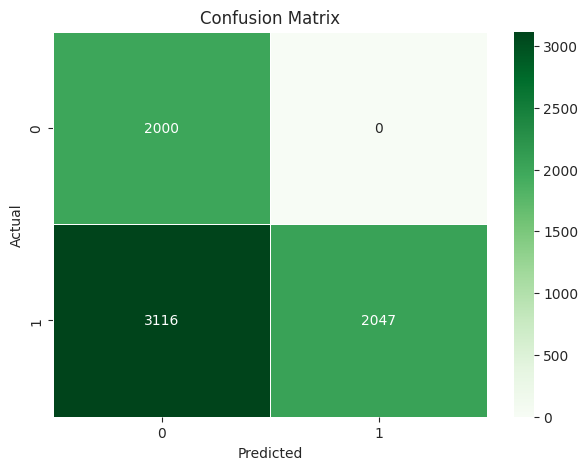

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

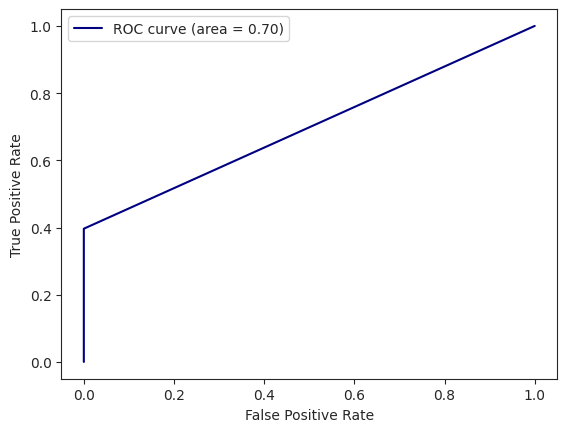

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
score = accuracy_score(y_test, y_test_pred, normalize=True) * float(100)
print(score)

56.49867374005305


In [ ]:
import pickle

# Save the trained XGBoost model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
data1 = pd.read_csv('/content/drive/My Drive/Data/facebook_combined.csv')
data1.columns = ['source_node', 'destination_node']

# Extract 1 lakh distinct nodes using .loc to avoid SettingWithCopyWarning
distinct_nodes = pd.concat([data1['source_node'], data1['destination_node']]).unique()[:10000]

filtered_data = data1[
    (data1['source_node'].isin(distinct_nodes) & (data1['source_node'] <= 10000)) &
    (data1['destination_node'].isin(distinct_nodes) & (data1['destination_node'] <= 10000))
]

# Map nodes to new ranks starting from 1
node_mapping = {node: idx + 1 for idx, node in enumerate(distinct_nodes)}

# Use .loc to avoid SettingWithCopyWarning
filtered_data.loc[:, 'source_node'] = filtered_data['source_node'].map(node_mapping)
filtered_data.loc[:, 'destination_node'] = filtered_data['destination_node'].map(node_mapping)


# Save the filtered data to a file named "facebook_combined1.csv"
filtered_data.to_csv('facebook_combined1.csv', index=False)
data1=filtered_data
print(data1)

       source_node  destination_node
15               4              5363
44              15              6383
70              21              1227
92              22              3465
372             79              2844
...            ...               ...
52112         8470              7203
52127         8472              2906
52232         8488              7463
52267         8492               353
52351         8509              1448

[289 rows x 2 columns]


<ipython-input-70-eabb733cdbef>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'source_node'] = filtered_data['source_node'].map(node_mapping)
<ipython-input-70-eabb733cdbef>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'destination_node'] = filtered_data['destination_node'].map(node_mapping)


In [ ]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.7 MB/s eta 0:00:00


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


In [ ]:
# import dgl.data

# dataset = dgl.data.CoraGraphDataset()
src_nodes = data1['source_node'].to_numpy()
dst_nodes = data1['destination_node'].to_numpy()

# Create a DGL graph
g = dgl.graph((src_nodes, dst_nodes))

In [ ]:
print(g)

Graph(num_nodes=8510, num_edges=289,
      ndata_schemes={}
      edata_schemes={})


In [ ]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [ ]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [ ]:
from dgl.nn import SAGEConv

class GraphSAGEWithoutFeatures(nn.Module):
    def __init__(self, h_feats):
        super(GraphSAGEWithoutFeatures, self).__init__()
        self.conv1 = SAGEConv(in_feats=1, out_feats=h_feats, aggregator_type='mean')
        self.conv2 = SAGEConv(in_feats=h_feats, out_feats=h_feats, aggregator_type='mean')

    def forward(self, g):
        # Use a constant tensor as initial features
        in_feat = torch.ones(g.number_of_nodes(), 1)  # Assuming 1-dimensional initial features
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Example usage
# Assuming 'g' is your DGL graph



In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']



In [ ]:
model_without_features = GraphSAGEWithoutFeatures(h_feats=16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In epoch 0, loss: 3.571495294570923
In epoch 5, loss: 1.3173478841781616
In epoch 10, loss: 0.6569739580154419
In epoch 15, loss: 0.496654748916626
In epoch 20, loss: 0.4616328775882721
In epoch 25, loss: 0.45026612281799316
In epoch 30, loss: 0.4442950189113617
In epoch 35, loss: 0.43356412649154663
In epoch 40, loss: 0.42514437437057495
In epoch 45, loss: 0.4210519790649414
In epoch 50, loss: 0.4174911379814148
In epoch 55, loss: 0.4147689938545227
In epoch 60, loss: 0.41180163621902466
In epoch 65, loss: 0.40908560156822205
In epoch 70, loss: 0.4064572751522064
In epoch 75, loss: 0.4038902521133423
In epoch 80, loss: 0.4016178846359253
In epoch 85, loss: 0.39945077896118164
In epoch 90, loss: 0.3972688317298889
In epoch 95, loss: 0.3951398432254791
AUC 0.7857142857142857


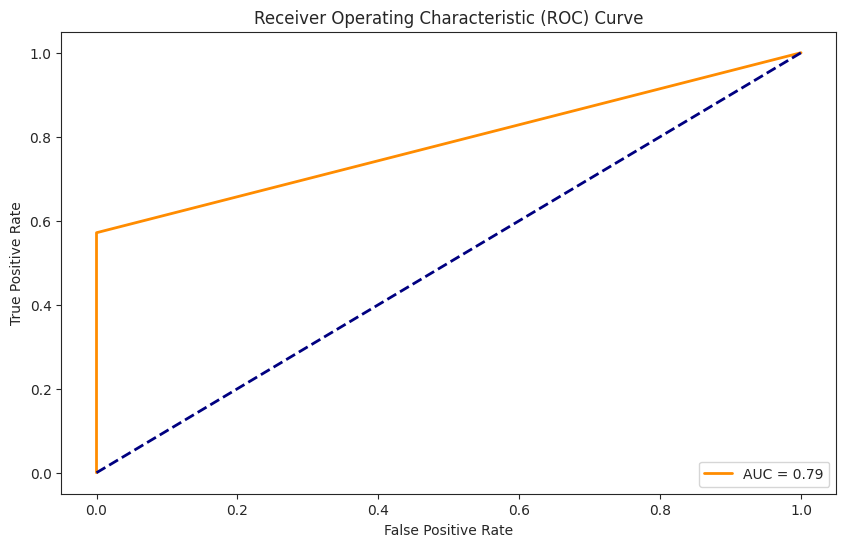

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
optimizer = torch.optim.Adam(itertools.chain(model_without_features.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model_without_features(train_g)
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    # Assuming 'test_g' is your test graph
    pos_score = pred(test_pos_g, h)

    # For negative examples, you might want to create a new graph similar to 'test_g' with negative edges
    # neg_score = pred(test_neg_g, model_without_features(test_g))
    # Adjust this part based on how your negative examples are organized

    # For simplicity, let's assume you don't have explicit negative examples for testing
    neg_score = pred(test_neg_g, h)  # This line may need adjustment based on your data

    print('AUC', compute_auc(pos_score, neg_score))
    labels = [1] * len(pos_score) + [0] * len(neg_score)
    scores = torch.cat([pos_score, neg_score]).numpy()

    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_path = 'graphsage_without_features.pth'
torch.save(model_without_features.state_dict(), model_path)

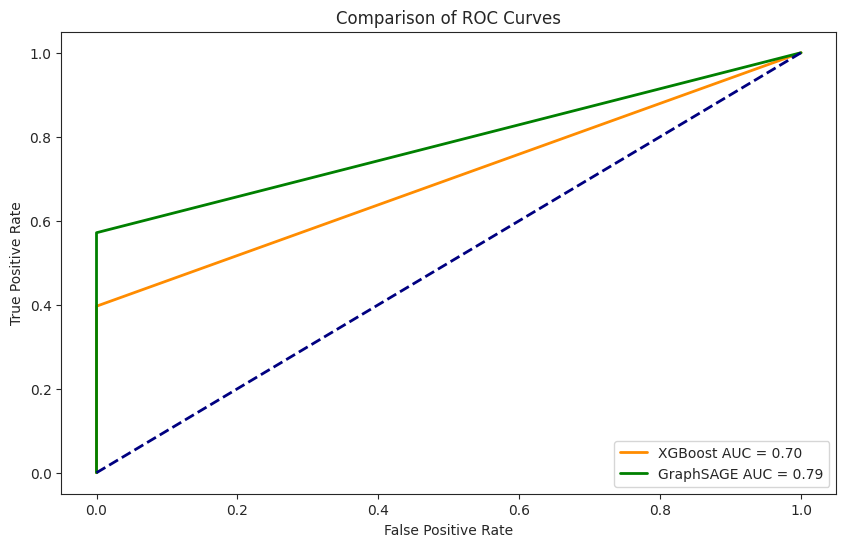

XGBoost Test F1 score: 0.5678224687933425
GraphSAGE Test F1 score: 0.6976744186046512


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

# Assuming you have y_test and y_test_pred for the XGBoost model
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_test_pred)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Assuming you have computed fpr, tpr, and roc_auc for the GraphSAGE model
# (you might need to adjust this part based on your actual implementation)
fpr_graphsage, tpr_graphsage, thresholds_graphsage = roc_curve(labels, scores)
roc_auc_graphsage = auc(fpr_graphsage, tpr_graphsage)

# Plot ROC curves for both models on the same plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost AUC = {roc_auc_xgb:.2f}')
plt.plot(fpr_graphsage, tpr_graphsage, color='green', lw=2, label=f'GraphSAGE AUC = {roc_auc_graphsage:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Print F1 scores for both models
print('XGBoost Test F1 score:', f1_score(y_test, y_test_pred))
# Assuming you have y_test and pos_score, neg_score for the GraphSAGE model
# (you might need to adjust this part based on your actual implementation)
y_pred_graphsage = [1 if score > 0.5 else 0 for score in scores]
print('GraphSAGE Test F1 score:', f1_score(labels, y_pred_graphsage))

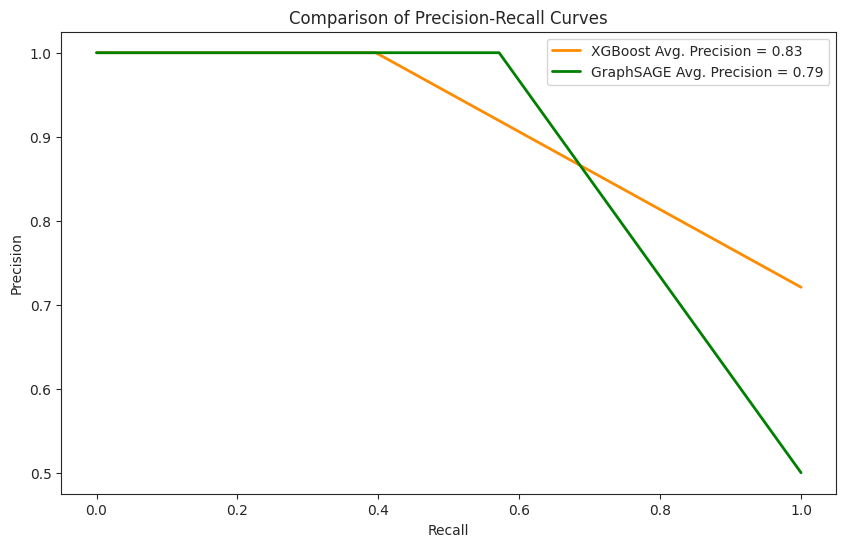

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming you have y_test and y_test_pred for the XGBoost model
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_pred)
average_precision_xgb = average_precision_score(y_test, y_test_pred)

# Assuming you have computed precision, recall, and average_precision for the GraphSAGE model
precision_graphsage, recall_graphsage, _ = precision_recall_curve(labels, scores)
average_precision_graphsage = average_precision_score(labels, scores)

# Plot Precision-Recall curves for both models
plt.figure(figsize=(10, 6))
plt.plot(recall_xgb, precision_xgb, color='darkorange', lw=2, label=f'XGBoost Avg. Precision = {average_precision_xgb:.2f}')
plt.plot(recall_graphsage, precision_graphsage, color='green', lw=2, label=f'GraphSAGE Avg. Precision = {average_precision_graphsage:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparison of Precision-Recall Curves')
plt.legend(loc='upper right')
plt.show()


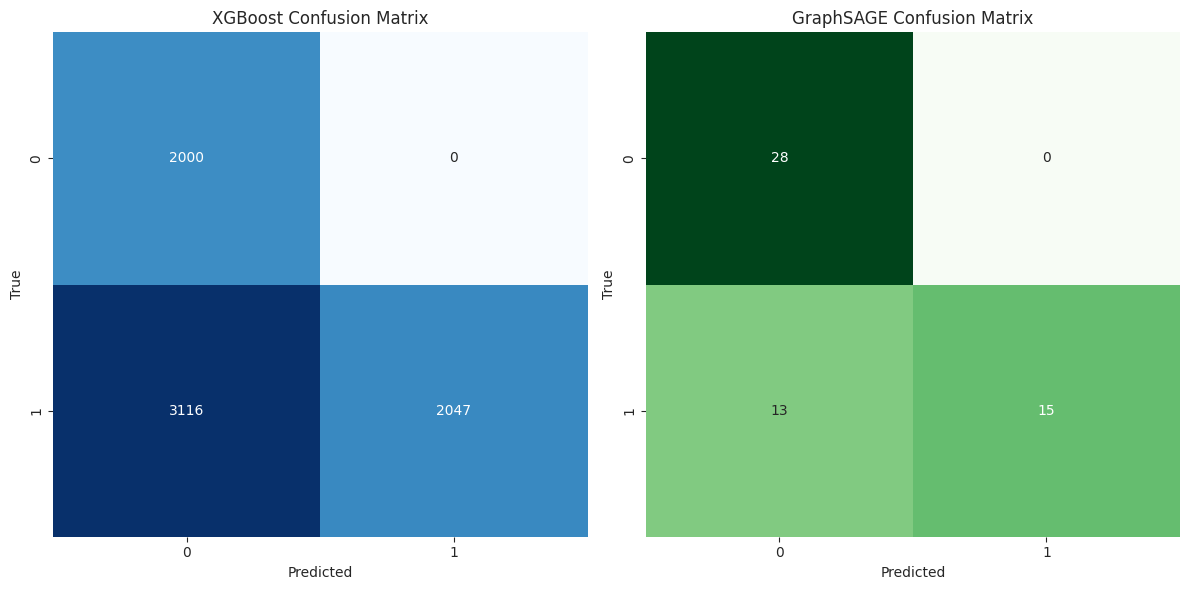

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have y_test and y_test_pred for the XGBoost model
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred)

# Assuming you have y_test and y_pred_graphsage for the GraphSAGE model
conf_matrix_graphsage = confusion_matrix(labels, y_pred_graphsage)

# Plot confusion matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_graphsage, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('GraphSAGE Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


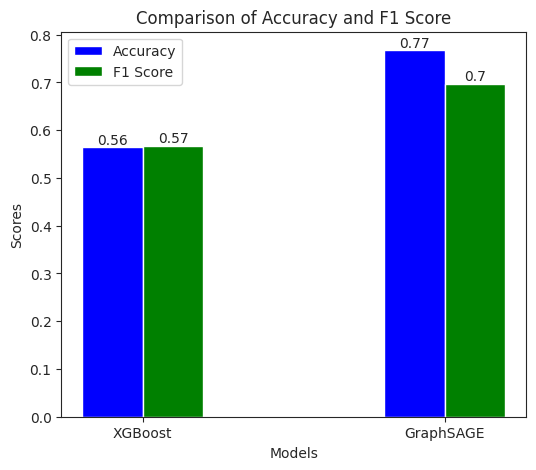

XGBoost Test F1 score: 0.5678224687933425
XGBoost Test Accuracy: 0.5649867374005305
GraphSAGE Test F1 score: 0.6976744186046512
GraphSAGE Test Accuracy: 0.7678571428571429


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# Calculate accuracy and F1 score for both models
accuracy_xgb = accuracy_score(y_test, y_test_pred)
f1_xgb = f1_score(y_test, y_test_pred)

accuracy_graphsage = accuracy_score(labels, y_pred_graphsage)
f1_graphsage = f1_score(labels, y_pred_graphsage)

# Create bar chart
models = ['XGBoost', 'GraphSAGE']
accuracy_scores = [accuracy_xgb, accuracy_graphsage]
f1_scores = [f1_xgb, f1_graphsage]

bar_width = 0.2
index = np.arange(len(models))

plt.figure(figsize=(6, 5))
bar1 = plt.bar(index, accuracy_scores, bar_width, label='Accuracy', color='b')
bar2 = plt.bar(index + bar_width, f1_scores, bar_width, label='F1 Score', color='g')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Accuracy and F1 Score')
plt.xticks(index + bar_width / 2, models)
plt.legend()

# Add values on top of the bars
for bar in [bar1, bar2]:
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, round(height, 2),
                 ha='center', va='bottom')

plt.show()
print('XGBoost Test F1 score:', f1_score(y_test, y_test_pred))
print('XGBoost Test Accuracy:', accuracy_xgb)

print('GraphSAGE Test F1 score:', f1_score(labels, y_pred_graphsage))
print('GraphSAGE Test Accuracy:', accuracy_graphsage)

Enter the number of nodes: 5
Enter the number of edges: 5
Enter edge 1 in the format 'source -> destination': 1->2
Enter edge 2 in the format 'source -> destination': 1->3
Enter edge 3 in the format 'source -> destination': 3->4
Enter edge 4 in the format 'source -> destination': 4->2
Enter edge 5 in the format 'source -> destination': 5->3


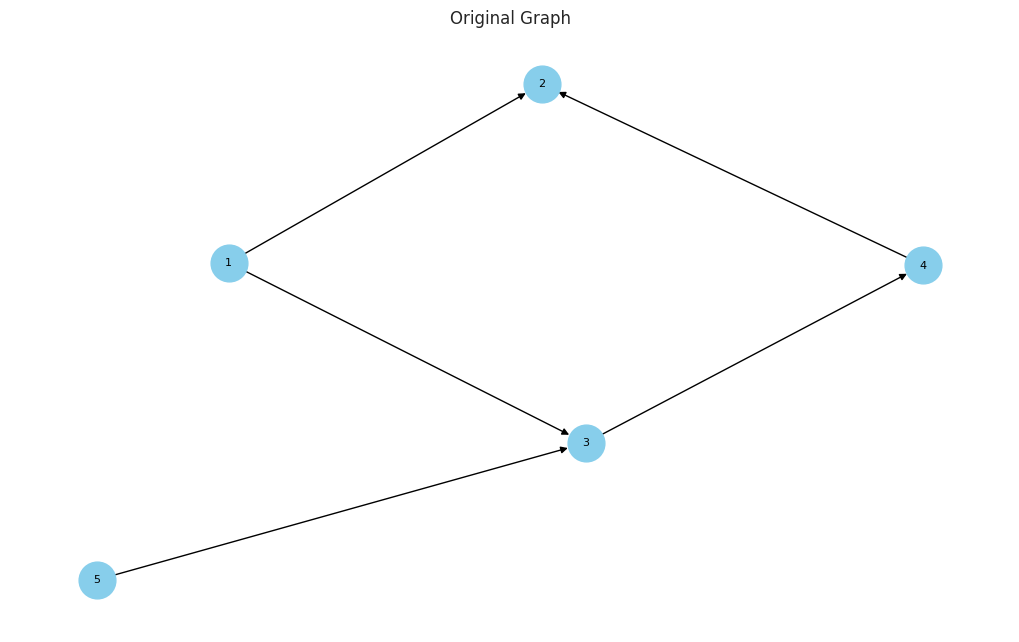

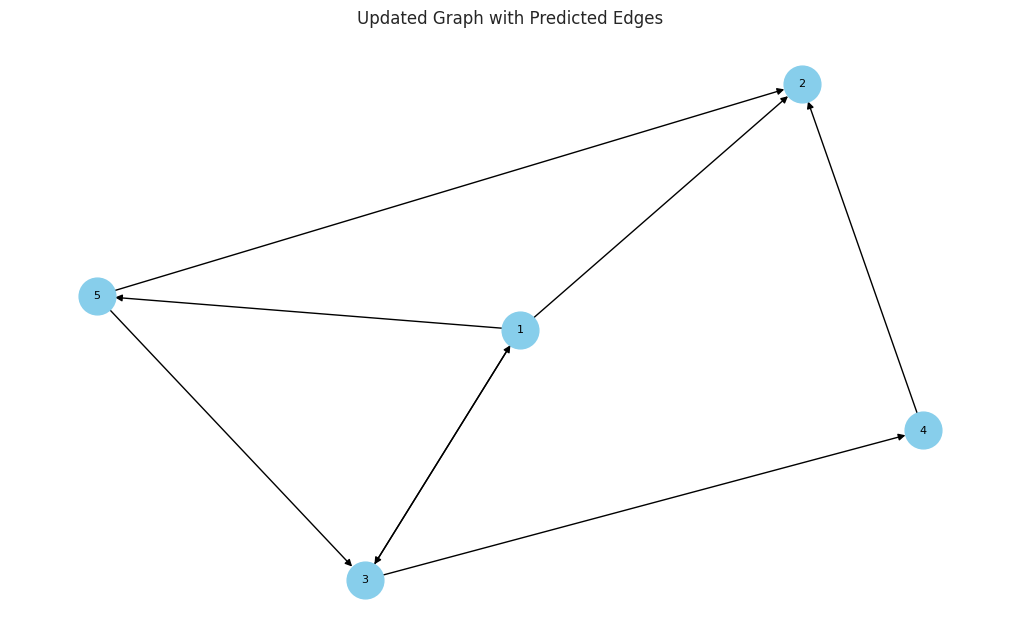

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def jaccard_distance_followees(graph, node_x, node_y):
    set_followees_x = set(graph.predecessors(node_x))
    set_followees_y = set(graph.predecessors(node_y))

    if len(set_followees_x.union(set_followees_y)) == 0:
        return 0.0
    else:
        jaccard_distance = 1 - len(set_followees_x.intersection(set_followees_y)) / len(set_followees_x.union(set_followees_y))
        return jaccard_distance

def jaccard_distance_followers(graph, node_x, node_y):
    set_followers_x = set(graph.successors(node_x))
    set_followers_y = set(graph.successors(node_y))

    if len(set_followers_x.union(set_followers_y)) == 0:
        return 0.0
    else:
        jaccard_distance = 1 - len(set_followers_x.intersection(set_followers_y)) / len(set_followers_x.union(set_followers_y))
        return jaccard_distance

def adar_index(g, a, b):
    total = 0
    try:
        n = list(set(g.successors(a)).intersection(set(g.successors(b))))
        if len(n) != 0:
            for i in n:
                total += 1 / np.log10(len(list(g.predecessors(i))))
            return total
        else:
            return 0
    except:
        return 0

def compute_shortest_path_length(g, a, b):
    try:
        if g.has_edge(a, b):
            g.remove_edge(a, b)
            p = nx.shortest_path_length(g, source=a, target=b)
            g.add_edge(a, b)
        else:
            p = nx.shortest_path_length(g, source=a, target=b)
        return p
    except:
        return -1

def follows_back(g, a, b):
    return int(g.has_edge(b, a))

def calculate_jaccard_distance(g, source_node, destination_node, distance_function):
    if source_node not in g or destination_node not in g:
        return 0  # or handle missing nodes in a way that makes sense for your use case
    else:
        return distance_function(g, source_node, destination_node)

def extract_features(G, node1, node2):
    jaccard_followers = calculate_jaccard_distance(G, node1, node2, jaccard_distance_followers)
    jaccard_followees = calculate_jaccard_distance(G, node1, node2, jaccard_distance_followees)
    shortest_path_length = compute_shortest_path_length(G, node1, node2)
    adar_index_value = adar_index(G, node1, node2)
    follows_back_value = follows_back(G, node1, node2)
    features = np.array([jaccard_followers, jaccard_followees, shortest_path_length, adar_index_value, follows_back_value])
    return features

# Get user input for the number of nodes and edges
num_nodes = int(input("Enter the number of nodes: "))
num_edges = int(input("Enter the number of edges: "))

# Create directed graph using NetworkX
G = nx.DiGraph()

# Get user input for edges in the format "source -> destination"
for i in range(num_edges):
    edge_input = input(f"Enter edge {i + 1} in the format 'source -> destination': ")
    source, destination = map(str.strip, edge_input.split("->"))
    G.add_edge(source, destination)

# Visualize the original graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', arrowsize=10)
plt.title("Original Graph")
plt.show()

# Predict for all non-existing edges
predictions = {}
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2 and not G.has_edge(node1, node2):
            features = extract_features(G, node1, node2)
            # Perform prediction logic here using your model
            # For simplicity, let's assume predictions are random
            edge_score = np.random.rand()  # Replace with your model's prediction
            threshold = 0.9
            prediction = edge_score > threshold
            predictions[(node1, node2)] = prediction

# Add predicted edges to the graph
for (node1, node2), prediction in predictions.items():
    if prediction:
        G.add_edge(node1, node2)

# Visualize the updated graph with predicted edges
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', arrowsize=10)
plt.title("Updated Graph with Predicted Edges")
plt.show()
